# ANN Training and Validation

This exercise is split into two different parts, first you will be implementing and training a 2-layer neural network using a high level library, [pytorch](https://pytorch.org/). Secondly you will implement the neural network, the forward pass and the backward pass from scratch using numpy. The data which will be used is a subset of the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset which contains handwritten numbers from 0-9. Examples can be seen in the image below.

![MNIST digits](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)

## Literature
Before starting with the implementation you should familiarize yourself with relevant sections from the [deep learning book](https://www.deeplearningbook.org/). This will help you understand the theory behind neural networks and what mathematical formulas are important for the task. The lectures has touched on most of these concepts too. Below you can find a list of recommended sections from the book. If you feel that you are already familiar with the contents of the section, feel free to skip it.

* Chapter 5 - Machine learning basics
    - Section 5.1 - Explains the basics of what we mean by learning and what supervised learning is.
    - Section 5.2 - Talks about generalization, the generalization gap and under/overfitting.
    - Section 5.3 - Validation and validation set.
* Chapter 6 - Deep feedforward networks
    - Section 6.0 - Discusses what do we mean by feedfoward networks and terminology such as input layer, output layer and hidden layer.
    - Section 6.2 - Discusses what gradient based learning is and what cost functions are.
    - Section 6.5 - Explains back-propagation. Important here are the formulas 6.49 - 6.52.
    
## Examination

### Part 1
* Implementation of a 2 layer NN (very similar to ex0)
* Training of this 2 layer NN (once again, very similar to ex0)
* Validation of the network during training
    - Save the model which performs the best on the validation data
* Graph the training loss vs validation loss
* At least 85% accuracy on the validation data (remember to load the best performing model before performing the accuracy test)

### Part 2
* Implementation of a 2 layer NN using numpy
* Training and validation of the 2 layer NN
    - Once again, save the best performing model (can be done in memory)
* Graph the training vs validation loss
* At least 50% accuracy on the validation data (can be hard to get high accuracy)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# Part 1

## MNIST dataset preparation
We will start by downloading and preparing the data such that it is usable for our purposes. [skipped]

## Implement a classifier using pytorch

Given the code above, your knowledge from the literature, lectures and exercise 0. Implement a 2 layer neural network using pytorch. This network should be capable of being trained and validated. The weights of the model which performs the best on the validation data should be stored to make it easy to use them. You are free to choose any optimizer and loss function. Just note that some loss functions require the labels to be 1 hot encoded. **As you will not use convolutional layers (later in the course), the input needs to be changed to a 1d tensor (see [view](https://pytorch.org/docs/stable/tensors.html?highlight=view#torch.Tensor.view)).**

In [1]:
############################################################
####### Importing libraries
############################################################

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy
import copy
from torchsummary import summary


############################################################
####### Importing data
############################################################

# Define the mini-batch size
batch_size = 1000

# Download the dataset and create the dataloaders for training
mnist_train = datasets.MNIST("./", train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=False)

# Download the dataset and create the dataloaders for validation
mnist_validation = datasets.MNIST("./", train=False, download=True, transform=transforms.ToTensor())
validation_loader = DataLoader(mnist_validation, batch_size=batch_size, shuffle=False)

# Defining transformations to one-hot encode labels later
to_onehot = nn.Embedding(10, 10)
to_onehot.weight.data = torch.eye(10)


############################################################
####### Some funcs
############################################################


def predict_on_images(iterator, images_to_show):
    '''Shows a few pictures with its predicted values.'''
    for index in range(images_to_show):
        images, labels = next(iterator)   # Get the next batch of images
        plot_digit(images[0])

        input_tensor = images[0].view(1,784)          # Transform the images into a single list of pixels since our network takes that as its input
        prediction = network(input_tensor)            # Run the input through our network to get a prediction
        guess = torch.argmax(prediction[0], dim=-1)   # Extract which prediction had the highest probability

        print(f'Prediction: {guess.item()} - Actual: {labels[0].item()}') # Show the predicted digit and the actual digit


def plot_digit(data):
    '''Previews a picture from the dataset.'''
    data = data.view(28, 28)
    plt.imshow(data, cmap="gray")
    plt.show()


def get_epoch_loss(some_loader):
    '''Calculates the loss per epoch for a given data loader.
    Call this function from inside the training loop.
    Yes, it also works for plain loss outside the loop but it 
    doesn't make as much sense.'''
    loss_list = []
    for batch_nr, (images, labels) in enumerate(some_loader):
        labels = to_onehot(labels)
        images = images.view(-1,784)
        prediction = network(images)
        loss_list.append(loss_function(prediction, labels))
    return sum(loss_list)/len(loss_list)


def get_acc(some_loader):
    '''Computes the network's accuracy on an arbitrary data loader.'''
    matches = 0
    datapoints = 0
    for batch_nr, (images, labels) in enumerate(some_loader):
        labels = to_onehot(labels)
        images = images.view(-1,784)
        prediction = network(images)

        preds = prediction.detach().numpy()
        labls = labels.detach().numpy()

        matches += sum([numpy.argmax(preds[i]) == numpy.argmax(labls[i]) for i in range(len(preds))])
        datapoints += len(labels)
    return matches/datapoints



Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!





In [2]:
############################################################
####### Training
############################################################

# Define the network
network = nn.Sequential(
    nn.Linear(784, 100),
    nn.ReLU(),
    nn.Linear(100, 10)
    )

# Some hyperparameters
epochs = 30
lr = 1
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.SGD(network.parameters(), lr=lr)


# Training loop
train_losses = []
valid_losses = []
for epoch in range(epochs):
    for batch_nr, (images, labels) in enumerate(train_loader):

        # Reshape data & labels to match network
        labels = to_onehot(labels)
        images = images.view(-1,784)

        # Make a prediction and compute its loss
        prediction = network(images)
        loss = loss_function(prediction, labels)

        # Upgrade weights
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Print the epoch, batch, and loss
        print('\rEpoch {}/{} [{}/{}] - Loss: {}'\
            .format(epoch+1, epochs, batch_nr+1, len(train_loader), loss),end='')

    # Get losses per epoch for validation and train sets
    train_losses.append(get_epoch_loss(train_loader))
    valid_losses.append(get_epoch_loss(validation_loader))
    

Epoch 30/30 [60/60] - Loss: 0.00926976278424263


> ACCURACY ON TRAINING SET: 0.9637333333333333
> ACCURACY ON VALIDATION SET: 0.9601
> Hyperparameters:
	Training epochs: 30
	Loss function: MSE
	Optimizer: SGD
	Learning rate: 1
> MODEL: Sequential(
  (0): Linear(in_features=784, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=10, bias=True)


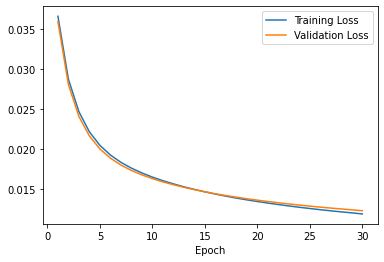

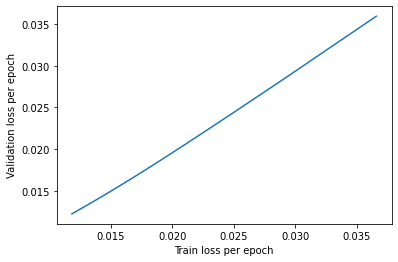

In [ ]:
############################################################
####### Evaluating & overengineered printing of data
############################################################


# String with information about model and results
log = str(f'''
> ACCURACY ON TRAINING SET: {get_acc(train_loader)}
> ACCURACY ON VALIDATION SET: {get_acc(validation_loader)}
> Hyperparameters:
\tTraining epochs: {epochs}
\tLoss function: MSE
\tOptimizer: SGD
\tLearning rate: {lr}
> MODEL: {str(network)[:-2]}''')

# Display on terminal
print(log)

''' 
# WE'VE NOT LOOKED INTO MOUNTING A DRIVE FOLDER YET
# THIS WAS USED WHILE WORKING ON A LOCAL PYTHON INSTALL
# Save all that info in a file           
with open("torchann1_log.txt", "a") as f:
    f.write('\n')
    f.write(log)
    f.write('\n\n')
    f.write(f'Training losses per epoch: {[float(i) for i in train_losses]}\n')
    f.write(f'Validation losses per epoch: {[float(i) for i in valid_losses]}\n')
    f.write('_' * 80)
'''

# Plot stored losses per epoch 
plt.plot(range(1,epochs+1), train_losses, label='Training Loss')
plt.plot(range(1,epochs+1), valid_losses, label='Validation Loss')
plt.legend(loc="upper right")
plt.xlabel('Epoch')
plt.show()

# Plot validation loss against training one
plt.plot(train_losses, valid_losses)
plt.xlabel('Train loss per epoch')
plt.ylabel('Validation loss per epoch')
plt.show()

        

# Part 2

## Implement a classifier using numpy
Implement a similar 2 layer neural network, without using a high-level machine learning library like pytorch. It should function the same as the network in task 1. The code block below contains code to change the training data from the DataLoader format to the "raw" numpy format. It also contains some comments to guide you in the right direction. **Please note that this solution should not "scale" hence it is 100% OK to just have two weight matrices variables.**

### The foward pass
This is easy. Recall that each differnt layer is calculated by the formula: 
$$ y = g(\mathbf{W}*\mathbf{x} + b) $$
where $W$ is the weight matrix, $x$ the input, $b$ the bias and $g$ the non-linearity. For this exercise you are allowed to put $b = 0$ for simplicity when calculating the backwards pass.

### Backward pass
This can be tricky. In canvas there is supplementary material which explains back propogation and all the maths behind it. It should be under Extra material > Summary - Backpropagation.pdf. This together with the course book should be enough material for you to be able to implement the training algorithm.

### Weight update
Once you have calculated the gradient of both weight matrixes, this is updated by:
$$ W_i = W_i - \gamma \dfrac{dL}{dW_i} $$
where $\gamma$ is the step size, or learning rate.

In [ ]:
############################################################
####### Importing libraries
############################################################

import numpy as np
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import copy
from torchsummary import summary


############################################################
####### Importing data
############################################################

# Define the mini-batch size
batch_size = 1000

# Download the dataset and create the dataloaders for training
mnist_train = datasets.MNIST("./", train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=False)

# Download the dataset and create the dataloaders for validation
mnist_validation = datasets.MNIST("./", train=False, download=True, transform=transforms.ToTensor())
validation_loader = DataLoader(mnist_validation, batch_size=batch_size, shuffle=False)

# Defining transformations to one-hot encode labels later
to_onehot = nn.Embedding(10, 10)
to_onehot.weight.data = torch.eye(10)


############################################################
####### Some funcs
############################################################

def relu_grad2(s):
    '''Derivative of the relu function for tensors'''
    return 1 * (s > 0)


def get_epoch_loss(some_loader):
    '''Get the loss per epoch for an arbitrary data loader. This is done for 
    each picture individually, then all losses are averaged to get an epoch's 
    loss.'''
    all_losses = []
    for batch_nr, (inputs, labels) in enumerate(some_loader):
        for i in range(batch_size):
            # Load one pic
            x = inputs[i].reshape((1, D_in))
            y = np.eye(10)[labels[i]]

            # Forward pass for one pic
            h = np.matmul(x, w1)
            h_relu = h * (h > 0)
            y_pred = np.matmul(h_relu, w2)

            # Loss func of this picture
            loss = sum(np.subtract(y, y_pred[0])**2)
            
            # Put each sample's lost on a list to average later (bc batchsize=1)
            all_losses.append(loss)

    return np.mean(all_losses)

def get_acc(some_loader):
    '''Measures the accuracy of a model for any w1 w2 weights stored in memory.
    This is a batched-input approach.'''
    matches = 0
    datapoints = 0
    for batch_nr, (inputs, labels) in enumerate(some_loader):

        # Load a bunch of pics and get rid of the nosy torch variable type
        x = np.array(inputs.view(-1,784).detach())
        y = np.array(to_onehot(labels).detach())

        # Forward pass
        h = np.matmul(x, w1)
        h_relu = h * (h > 0)
        y_pred = np.matmul(h_relu, w2)

        # Count number of matches and number of evaluated cases
        matches += sum([np.argmax(y_pred[i]) == np.argmax(y[i]) for i in range(len(y))])
        datapoints += len(y)
        
    return matches/datapoints


def get_acc_ext(some_loader, f1='w1.csv', f2='w2.csv'):
    ''' Measures the accuracy of a model with weights w1 w2 loaded from file.
    THIS IS YET ONLY FOR WORKING ON A LOCAL PYHTON INSTALL '''
    # Load weight matrices
    w1_file  = np.loadtxt(f1,delimiter=',')
    w2_file  = np.loadtxt(f2,delimiter=',')

    matches = 0
    datapoints = 0
    for batch_nr, (inputs, labels) in enumerate(some_loader):

        # Load a bunch of pics
        x = np.array(inputs.view(-1,784).detach())
        y = np.array(to_onehot(labels).detach())

        # Forward pass
        h = np.matmul(x, w1_file)
        h_relu = h * (h > 0)
        y_pred = np.matmul(h_relu, w2_file)
        
        # Count number of matches and number of evaluated cases
        matches += sum([np.argmax(y_pred[i]) == np.argmax(y[i]) for i in range(len(y))])
        datapoints += len(y)

    return matches/datapoints

In [ ]:
############################################################
####### Training - TAKES A BIG WHILE! (actually a big for)
############################################################

# Provided hyperparameters
D_in = 784   # Input size, images are 28x28 = 784 element vectors
D_out = 10   # Output size, 10 digit classes
H1 = 100     # Hidden layer size
gamma = 1e-5 # Learning rate

# Custom hyperparameters
epochs = 10


# Randomize initial weights
# Do not rerandomize for deeper training!
rerandomize = True
if rerandomize:
    w1 = np.random.randn(D_in, H1)
    w2 = np.random.randn(H1, D_out)
else:
    try:
        w1 = w1
        w2 = w2
    except:
        print('You chose not to rerandomize, however no old weights were found :S')
        print('Continuing with random weight matrices...')
        w1 = np.random.randn(D_in, H1)
        w2 = np.random.randn(H1, D_out)    
        
  
# Training 

# Storage for per-epoch accuracies
training_accuracies = []
validation_accuracies = []

# Storage for per-epoch average losses
training_losses = []
validation_losses = []

for epoch in range(epochs):

    for batch_nr, (inputs, labels) in enumerate(train_loader):
        #inputs = inputs.numpy()
        #labels = labels.numpy()

        for i in range(batch_size):
            # Load one pic
            x = inputs[i].reshape((1, D_in))
            y = np.eye(10)[labels[i]]

            # Layer 1 + relu activation
            h = np.matmul(x, w1)
            h_relu = h * (h > 0)

            # Layer 2
            y_pred = np.matmul(h_relu, w2)

            # Compute loss function (squared error), deliberately ignoring the 
            # linear transformation factor 1/Nsamples that defines the MEAN 
            # squared error.
            loss = sum(np.subtract(y, y_pred[0])**2)


            # Loss derivative w.r. to y_pred
            dL_dypred = -2 * np.subtract(y, y_pred)

            # Loss derivative w.r. to w2 (f2L is the recycled term on backprop)
            f2L = np.multiply(np.ones(dL_dypred.shape),
                              dL_dypred)  
            dL_dw2 = np.matmul(h_relu.T, f2L)   

            # Loss derivative w.r. to w1
            dL_dw1 = np.matmul(x.T,                                            
                               np.multiply(relu_grad2(np.matmul(x, w1)), 
                                           np.matmul(f2L, w2.T)))
            
            # Update weights
            w2 -= np.dot(gamma, dL_dw2)
            w1 -= np.dot(gamma, dL_dw1)

        # Loss display every 1000 samples (batch size) so as not to go bananas
        print('\rEpoch {}/{} - Loss: {}'.format(epoch+1, epochs, loss),end='')
    
    # Get these every epoch
    training_accuracies.append(get_acc(train_loader))
    validation_accuracies.append(get_acc(validation_loader))

    training_losses.append(get_epoch_loss(train_loader))
    validation_losses.append(get_epoch_loss(validation_loader))

print('')
print(f'FINAL TRAINING ACCURACY {get_acc(train_loader)}')
print(f'FINAL VALIDATION ACCURACY {get_acc(validation_loader)}')

'''
THIS IS ONLY FOR WORKING ON A LOCAL PYHTON INSTALL
# save trained weights for later
np.savetxt('w1.csv', w1, delimiter=',')
np.savetxt('w2.csv', w2, delimiter=',')
'''

Epoch 10/10 - Loss: 0.6823362300512698
FINAL TRAINING ACCURACY 0.5312166666666667
FINAL VALIDATION ACCURACY 0.5378


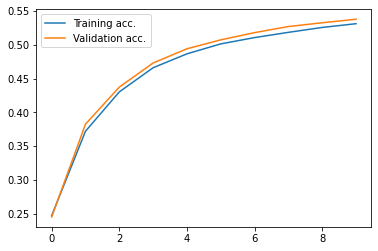

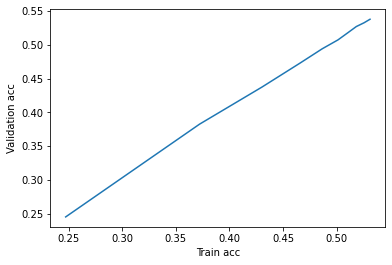

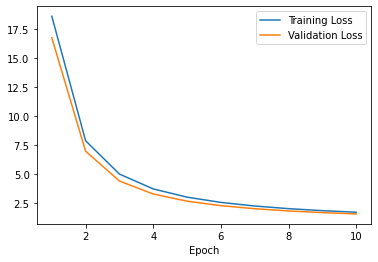

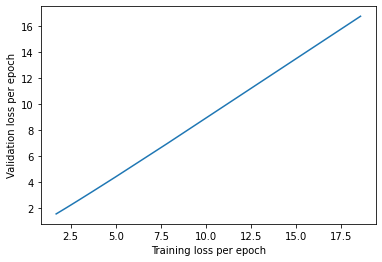

In [ ]:
# Plot stored accuracies per epoch 
plt.plot(range(len(training_accuracies)), training_accuracies, label='Training acc.')
plt.plot(range(len(validation_accuracies)), validation_accuracies, label='Validation acc.')
plt.legend()
plt.show()

# Plot training vs validation acuracy
plt.plot(training_accuracies, validation_accuracies)
plt.xlabel('Train acc')
plt.ylabel('Validation acc')
plt.show()

# Plot stored losses per epoch 
plt.plot(range(1,epochs+1), training_losses, label='Training Loss')
plt.plot(range(1,epochs+1), validation_losses, label='Validation Loss')
plt.legend(loc="upper right")
plt.xlabel('Epoch')
plt.show()

# Plot training vs validation loss
plt.plot(training_losses, validation_losses)
plt.xlabel('Training loss per epoch')
plt.ylabel('Validation loss per epoch')
plt.show()

In [ ]:
# Some functions that were not used but i want to store

def softmax_grad(s):
    '''Derivative of the softmax function.'''
    jacobian_m = np.diag(s)
    for i in range(len(jacobian_m)):
        for j in range(len(jacobian_m)):
            if i == j:
                jacobian_m[i][j] = s[i] * (1-s[i])
            else:
                jacobian_m[i][j] = -s[i]*s[j]
    return jacobian_m


# Optional task
You have now implemented a 2-layer neural network from scratch. Use this new gained knowledge to create an implementation where you can create and train any sized network. This means that you should be able to specify the structure of the network and then train it using back-propagation.

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./
    Split: Train
    StandardTransform
Transform: ToTensor()